# Task 3: Run Quantum Random Number Generator on Quantinuum Emulator

*In this task, you are already given all the code you’ll need! You need to set up the Azure Quantum connection information and use it to run this code on the Quantinuum emulator target.*

*To submit this task, update this notebook with the saved results of code cells execution and commit it in your challenge repository.*

## Submit a simple job to Quantinuum using Azure Quantum
Azure Quantum provides several ways to express quantum programs. In this example we are using [Qiskit](https://qiskit.org/), but note that Q# and Cirq are also supported. All code in this example will be written in Python.

Let's begin. When you see a code block, hover over it and click the triangle play-button to execute it. To avoid any compilation issues, this should be done in order from top to bottom.

### 1. Connect to the Azure Quantum workspace

To connect to the Azure Quantum service, construct an instance of the `AzureQuantumProvider`. Note that it's imported from `azure.quantum.qiskit`.

You need to substitute `<subscriptionId>`, `<resourceGroupId>`, `<workspaceId>`, and `<location>` in the connection string below with the parameter values from your own quantum workspace.
You can learn how to create an Azure Quantum workspace in [this Microsoft Learn module](https://docs.microsoft.com/learn/modules/get-started-azure-quantum/3-create-quantum-workspace).
(Executing this cell will open a new tab with a login prompt; return to the notebook once you log in.)

In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b",
    location = "westus"
)

Let's see what providers and targets are enabled in this workspace with the following command:

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)
[158010:158010:0100/000000.613443:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.


- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


### ❕ Do you see `quantinuum.hqs-lt-s2-apival` in your list of targets? If so, you're ready to keep going.

## Quantinuum: The quantum provider
Azure Quantum partners with third-party companies to deliver solutions to quantum jobs. These company offerings are called *providers*. Each provider can offer multiple *targets* with different capabilities. See the table below for Quantinuum's H1-2 device targets.

| Target name | Target ID | Number of qubits | Description|
| --- | ---| ---|---|
H1-2 API Validator | `quantinuum.hqs-lt-s2-apival` | 12 | Quantinuum's H1-2 Syntax Checker. Use this to validate quantum programs before submitting to hardware or emulation on Quantinuum's platform and check a quantum circuit's cost in H-Series Quantum Credits (HQCs). Free of cost. |
H1-2 Emulator | `quantinuum.hqs-lt-s2-sim` | 12 | Quantinuum's H1-2 emulator. Uses a realistic physical model and noise model that is consistent with the Quantinuum H1 hardware offering. |
H1-2 | `quantinuum.hqs-lt-s2` | 12 | Quantinuum's H1-2 trapped ion device. |

To start, we will use `quantinuum.hqs-lt-s2-apival` to avoid any costs or credit usage. To learn more about Quantinuum's targets, check out our [documentation](https://aka.ms/AQ/Quantinuum/Documentation).

### 2. Build the quantum program

Let's create a simple Qiskit circuit to run.

In [3]:
# Create a quantum circuit acting on a single qubit
circuit = QuantumCircuit(1,1)
circuit.name = "Single qubit random"
circuit.h(0)
circuit.measure(0, 0)

# Print out the circuit
circuit.draw()

┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

The circuit you built is a simple quantum random bit generator. With Quantinuum's API validator, we will be able to confirm that the circuit is able to be run on the Quantinuum H1-2 emulator and hardware.

### 3. Submit the quantum program to Quantinuum

In [4]:
# Create an object that represents Quantinuum's API validator target, "quantinuum.hqs-lt-s2-apival".
#   Note that any target you have enabled in this workspace can
#   be used here. Azure Quantum makes it extremely easy to submit
#   the same quantum program to different providers. 
quantinuum_api_val_backend = provider.get_backend("quantinuum.hqs-lt-s2-apival")

# Using the Quantinuum target, call "run" to submit the job. We'll
# use a count of 100 (simulated runs).
job_api_val = quantinuum_api_val_backend.run(circuit, count=100)
print("Job id:", job_api_val.id())

Job id: d2195e96-b846-11ec-bbd2-9843fa02ff35


The job ID can be used to retrieve the results later using the [get_details function](https://docs.microsoft.com/en-us/azure/quantum/optimization-job-reference#jobdetails) or by viewing it under the **Job management** section of the portal.

### 4. Obtain the job results
You can monitor the job status with Qiskit's `job_monitor` function.

This may take a minute or so ⏳. Your job will be packaged and sent to Quantinuum, where it will wait its turn to be run. You'll see your job go through these stages: "job is queued" &rarr; "job is actively running" &rarr; "job has successfully run."

Job Status: job has successfully run


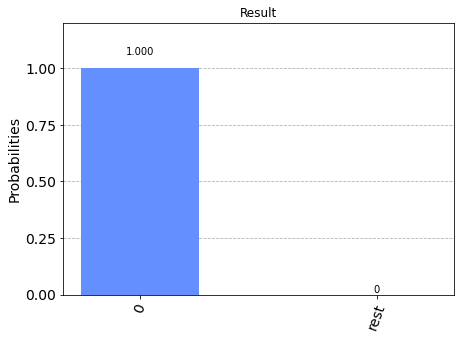

In [5]:
job_monitor(job_api_val)

result_api_val = job_api_val.result()

# The result object is native to the Qiskit package, so we can use Qiskit's tools to print the result as a histogram.
# For API validation, we expect to see all zeroes.
plot_histogram(result_api_val.get_counts(circuit), title="Result", number_to_keep=2)

**See the histogram above? Congratulations, you've submitted a job with Azure Quantum! 👏**


### 5. Estimate costs

To estimate the costs of running this program on the emulator, you can use the `backend.estimate_cost` method.

In [6]:
# Create an object that represents Quantinuum's API emulator target, "quantinuum.hqs-lt-s2-sim".
quantinuum_sim_backend = provider.get_backend("quantinuum.hqs-lt-s2-sim")
cost = quantinuum_sim_backend.estimate_cost(circuit, shots=100)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 5.12 EHQC


### 6. Submit the job to the emulator

Next, run the same program on Quantinuum's H1-2 emulation targets. Just replace `quantinuum.hqs-lt-s2-apival` with `quantinuum.hqs-lt-s2-sim`.

To learn more about submitting Qiskit circuits to Azure Quantum, review [this documentation](https://docs.microsoft.com/azure/quantum/quickstart-microsoft-qiskit?pivots=platform-quantinuum).

In [7]:
# Using the Quantinuum target target, call "run" to submit the job. We'll
# use a count of 100 (simulated runs).
job_sim = quantinuum_sim_backend.run(circuit, count=100)
print("Job id:", job_sim.id())

Job id: 186ab868-b847-11ec-bbd2-9843fa02ff35


Job Status: job has successfully run


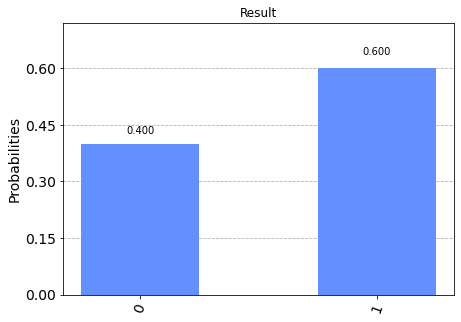

In [8]:
job_monitor(job_sim)

result_sim = job_sim.result()

# The result object is native to the Qiskit package, so we can use Qiskit's tools to print the result as a histogram.
# For running on an emulator, we expect to see random bits generated.
plot_histogram(result_sim.get_counts(circuit), title="Result")